If economic indicator is totally determined by stock price and noise, Multi Layer Nueral Network is good enough to learn that relationships.

Let's try it out!

In [1]:
!pip install matplotlib --upgrade
!pip install theano

Requirement already up-to-date: matplotlib in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy>=1.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pytz in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: cycler in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,>=1.5.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Cleaning up...
Cleaning up...


In [2]:
#generic
%matplotlib inline
from __future__ import print_function

#public open pakcages and methods
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#private pakcages and methods
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter

#for testing
from IPython import display
import platform
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
! pip install quandl

Cleaning up...


In [4]:
input_list = ["AAPL", "ORCL", "IBM", "INTC"]
energy = ["PTR", "XOM", "CVX", "RDS-A"]
financial = ["WFC", "JPM", "HSBC", "BAC"]
healthcare = ["NVX", "PFE", "MRK"]
hardware = ["AAPL", "ORCL", "IBM", "INTC"]
software = ["MSFT", "GOOGL", "FB"]
input_list = energy + financial + healthcare + hardware + software

In [6]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    for d in data_it:
        return_data.append(d[key])
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data = []
    date = []
    for share in share_list:
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data.append(map(float, get_data_by_key(key=data_type, data=hist_data)))
        date.append(get_data_by_key(key='Date', data=hist_data))
    return np.array(stock_data).T, date

In [7]:
import quandl 

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Open'])

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data_pred = np.array(sp['Open'])

In [70]:
import numpy as np
import theano 
import theano.tensor as T
from theano.tensor.nnet import relu
from itertools import izip

class HiddenLayer(object):
    def __init__(self, shape, W=None, b=None, input=None, activation=relu):
        """Set Hidden Lyaer properties
        Args:
            shape (List(int)): determine layer shape as (n_in, n_out)
            W (theano.shared): intialize weight if you give some W
            b (theano.shared): intialize bias if you give some b
            activation: activation function
        """
        
        self.shape = shape
        self.activation = activation  
        
        if W is None:
            W_values = np.asarray(
                np.random.uniform(
                    low=-np.sqrt(6./np.sum(shape)), 
                    high=np.sqrt(6./np.sum(shape)),
                    size=shape
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=W_values, name="W", borrow=True)
            
        if b is None:
            b_values = np.zeros(shape[1], dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name="b", borrow=True)
            
        self.W = W
        self.b = b
        self.params = [self.W, self.b]
        
    def batch_set_input(self, batch_input):
        self.batch_input = batch_input
        self.batch_output = self.activation(T.dot(self.batch_input, self.W) + self.b)
        
    def set_input(self, input):
        self.input = input
        self.output = self.activation(T.dot(self.input, self.W) + self.b)
        
    def output(self, x):
        y = self.activation(T.dot(x, self.W) + self.b)
        return y
        
class MLP(object):
    
    def __init__(self, *layers):
        """Get layer architecture
        Args:
            layers(list): contain each layer obejct like
                [HiddenLaer(10, 10), HiddenLayer(10, 10), HiddenLayer(10, 1)]
        """
        
        self.N_layers = len(layers)
        self.layers = layers
        
        # setting the input and output for training
        self.batch_input = T.dmatrix("batch_input")
        batch_input = self.batch_input
        for layer in self.layers:
            layer.batch_set_input(batch_input)
            batch_input = layer.batch_output
        self.batch_output = self.layers[-1].batch_output
        
        # setting the input and output
        self.input = T.dvector("input")
        input = self.input
        for layer in self.layers:
            layer.set_input(input)
            input = layer.output
        self.output = self.layers[-1].output
        
        self.output_func = theano.function(inputs=[self.input], outputs=self.output)
        self.batch_output_func = theano.function(inputs=[self.batch_input], outputs=self.batch_output)
        
        #setting parameters
        self.params = [param for layer in self.layers for param in layer.params]
    
            
    def SGD(self, input_data, target_data,
            learning_rate=0.01, L1_reg=0.00, L2_reg=0.0001, N_epochs=10000, batch_size=20):
    
        df_input = np.log(input_data[1:] / input_data[:-1])
        df_target = np.log(target_data[1:] / target_data[: -1])
        N_data = len(df_target)
        N_batches = N_data / batch_size
        
        df_input = theano.shared(value=np.array(df_input, dtype=theano.config.floatX))
        df_target = theano.shared(value=np.array(df_target, dtype=theano.config.floatX).reshape(N_data, 1))
            
        print ("...building the model")
        
        index = T.lscalar("index")
        target = T.dmatrix("target")
        cost = T.sum((target - self.batch_output) ** 2)
        
        gparams = [T.grad(cost=cost, wrt=param) for param in self.params]
        
        updates = [
            (param, param - learning_rate * gparam) for param, gparam in izip(self.params, gparams)
        ]
        
        batch_begin = index * batch_size
        batch_end = batch_begin + batch_size
        
        train_func = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens = {
                self.batch_input:
                    df_input[batch_begin: batch_end],
                target:
                    df_target[batch_begin: batch_end]
            }
        )
        
        print ("...training")
        
        print_epoch = 100
        
        for epoch in xrange(N_epochs):
            cost_data = []
            batch_list = np.arange(N_batches)
            np.random.shuffle(batch_list)
            for batch_index in iter(batch_list):
                c = train_func(batch_index)
                cost_data.append(c)
            average_cost = np.mean(cost_data) / batch_size
            
            if (epoch + 1) % print_epoch == 0:
                print ("epoch %d: cost = %f" % (epoch + 1, average_cost))
                
                
    def predict(self, input_data):
        df_input = np.log(input_data[1:] / input_data[:-1])
        out = self.batch_output_func(df_input)
        accumulated = np.cumprod( np.exp(out))
        return accumulated

In [83]:
mlp = MLP(HiddenLayer(shape=(18, 100)), HiddenLayer(shape=(100, 1000)),  HiddenLayer(shape=(1000, 100)),
    HiddenLayer(shape=(100, 1), activation=lambda x: x))

mlp.SGD(input_data, target_data, N_epochs=10000, learning_rate=0.001)

...building the model
...training
epoch 100: cost = 0.000049
epoch 200: cost = 0.000044
epoch 300: cost = 0.000042
epoch 400: cost = 0.000041
epoch 500: cost = 0.000040
epoch 600: cost = 0.000040
epoch 700: cost = 0.000039
epoch 800: cost = 0.000039
epoch 900: cost = 0.000039
epoch 1000: cost = 0.000038
epoch 1100: cost = 0.000038
epoch 1200: cost = 0.000038
epoch 1300: cost = 0.000037
epoch 1400: cost = 0.000037
epoch 1500: cost = 0.000037
epoch 1600: cost = 0.000037
epoch 1700: cost = 0.000037
epoch 1800: cost = 0.000036
epoch 1900: cost = 0.000036
epoch 2000: cost = 0.000036
epoch 2100: cost = 0.000036
epoch 2200: cost = 0.000036
epoch 2300: cost = 0.000036
epoch 2400: cost = 0.000035
epoch 2500: cost = 0.000035
epoch 2600: cost = 0.000035
epoch 2700: cost = 0.000035
epoch 2800: cost = 0.000035
epoch 2900: cost = 0.000035
epoch 3000: cost = 0.000035
epoch 3100: cost = 0.000035
epoch 3200: cost = 0.000035
epoch 3300: cost = 0.000035
epoch 3400: cost = 0.000034
epoch 3500: cost = 0.00

prediction time: 0.0439291000366


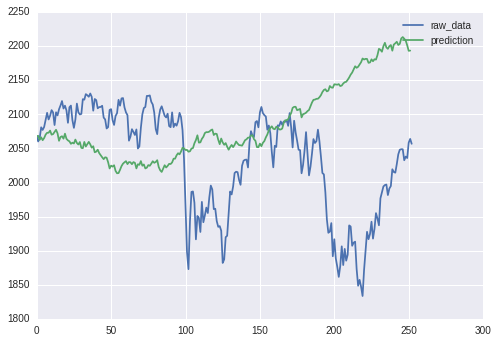

In [84]:
import time

st = time.time()
output_data_pred = target_data_pred[0] * mlp.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()